# 1. Data Preparation

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchani

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
def load_ani_dataset(dspath):
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

In [7]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


In [8]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

# 2. Network Construction and Workflow Development

## 2.1. ANITrainer

In [11]:
import torch.optim as optim
import matplotlib.pyplot as plt

In [12]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(batch_size=self.batch_size).cache()
        train_data_batch = next(iter(train_data_loader))

        # definition of loss function: MSE is a good choice! 
        loss_func = nn.MSELoss()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            num_samples = 0
            for train_data_batch in train_data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                # compute energies
                _, pred_energies = self.model((species, coords))
                
                # compute loss
                batch_loss = loss_func(true_energies, pred_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = species.shape[0]
                train_epoch_loss += batch_loss.item() * batch_importance
                num_samples += batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            train_epoch_loss /= num_samples
            val_epoch_loss = self.evaluate(val_data)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(batch_size=self.batch_size).cache()
        train_data_batch = next(iter(train_data_loader))

        # init loss function
        loss_func = nn.MSELoss()
        total_loss = 0.0
        num_samples = 0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                # compute energies
                _, pred_energies = self.model((species, coords))
                 
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)

                batch_importance = species.shape[0]
                total_loss += batch_loss.item() * batch_importance
                num_samples += batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        total_loss /= num_samples

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

## 2.2. Demonstration on a subset

Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 10/10 [01:12<00:00,  7.22s/it]


Validation Loss: 7.435047816464e-05


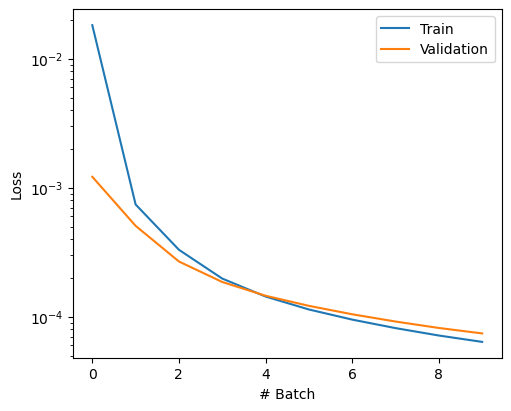

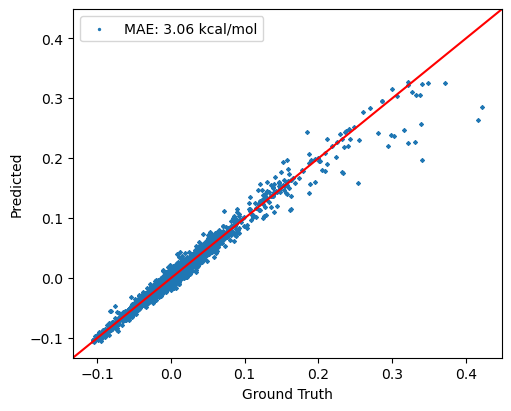

In [26]:
# train the ANITrainer
trainer = ANITrainer(model, batch_size=4096, learning_rate=1e-4, epoch=10, l2=1e-5)
train_loss_list, val_loss_list = trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
val_loss = trainer.evaluate(val_data, draw_plot=True)
print("Validation Loss:", val_loss)

# 3. Regularization and Hyperparameter Tuning

## 3.1. Data Augmentation

In [16]:
!curl -L https://ndownloader.figshare.com/files/9057631 -o ANI1_release.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4584M  100 4584M    0     0  12.8M      0  0:05:57  0:05:57 --:--:-- 19.8M97k


In [21]:
!tar -xzf ANI1_release.tar.gz

In [11]:
import h5py
import glob

def merge_hdf5_groups(input_dir, output_file):
    # file_list = sorted(glob.glob(f"{input_dir}/ani_gdb_s0*.h5"))
    file_list = sorted(glob.glob(f"{input_dir}/ani_gdb_s0[1-6].h5"))
    if not file_list:
        print("No HDF5 files found in the input directory")
        return
    
    with h5py.File(output_file, 'w') as fout:
        for file in file_list:
            print(f"Processing {file}...")
            with h5py.File(file, 'r') as fin:
                for key in fin.keys():
                    new_key = key
                    suffix = 1
                    while new_key in fout:
                        new_key = f"{key}_{suffix}"
                        suffix += 1
                    fin.copy(key, fout, new_key)
                    print(f"Copied group '{key}' as '{new_key}'")
    print(f"Merged groups from {len(file_list)} files into {output_file}")


input_directory = "./ANI-1_release"
output_h5_file = "./ani_gdb_s01_to_s06.h5"
merge_hdf5_groups(input_directory, output_h5_file)

Processing ./ANI-1_release/ani_gdb_s01.h5...
Copied group 'gdb11_s01' as 'gdb11_s01'
Processing ./ANI-1_release/ani_gdb_s02.h5...
Copied group 'gdb11_s02' as 'gdb11_s02'
Processing ./ANI-1_release/ani_gdb_s03.h5...
Copied group 'gdb11_s03' as 'gdb11_s03'
Processing ./ANI-1_release/ani_gdb_s04.h5...
Copied group 'gdb11_s04' as 'gdb11_s04'
Processing ./ANI-1_release/ani_gdb_s05.h5...
Copied group 'gdb11_s05' as 'gdb11_s05'
Processing ./ANI-1_release/ani_gdb_s06.h5...
Copied group 'gdb11_s06' as 'gdb11_s06'
Merged groups from 6 files into ./ani_gdb_s01_to_s06.h5


In [13]:
# Reload the dataset with augmented ANI-1 dataset
dataset = load_ani_dataset("./ani_gdb_s01_to_s04.h5")
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

In [14]:
# Initialize aev computer
aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


## 3.2. Regularization

In [15]:
# Apply Dropout
class AtomicNet(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [16]:
def create_ani_model(dropout_rate=0.0):
    net_H = AtomicNet(dropout_rate)
    net_C = AtomicNet(dropout_rate)
    net_N = AtomicNet(dropout_rate)
    net_O = AtomicNet(dropout_rate)

    # ANI model requires a network for each atom type
    # use torch.ANIModel() to compile atomic networks
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    model = nn.Sequential(
        aev_computer,
        ani_net
    ).to(device)
        
    return model

In [17]:
# We already had L2 regularization as `weight_decay`
# Add L1 regularization term
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2, l1=0.0):
        self.model = model.to(device)
        
        # Count total number of parameters
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        # Hyperparameters setting
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        self.l1 = l1  # L1 regularization strength

    def train(self, train_data, val_data, early_stop=True, draw_curve=False):
        self.model.train()
        print("Initializing training data...")
        train_data_loader = train_data.collate(batch_size=self.batch_size).cache()
        
        loss_func = nn.MSELoss()
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        best_weights = None

        for epoch_idx in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            num_samples = 0
            for train_data_batch in train_data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                _, pred_energies = self.model((species, coords))
                batch_loss = loss_func(true_energies, pred_energies)
                
                # Add L1 regularization loss
                if self.l1 > 0:
                    l1_loss = 0.0
                    for param in self.model.parameters():
                        l1_loss += torch.norm(param, 1)
                    batch_loss += self.l1 * l1_loss
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_size_current = species.shape[0]
                train_epoch_loss += batch_loss.item() * batch_size_current
                num_samples += batch_size_current

            train_epoch_loss /= num_samples
            train_loss_list.append(train_epoch_loss)
            val_epoch_loss = self.evaluate(val_data)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    best_weights = self.model.state_dict().copy()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            plt.show()
        
        if early_stop and best_weights is not None:
            self.model.load_state_dict(best_weights)
        
        return train_loss_list, val_loss_list

    def evaluate(self, data, draw_plot=False):
        data_loader = data.collate(batch_size=self.batch_size).cache()
        loss_func = nn.MSELoss()
        total_loss = 0.0
        num_samples = 0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
        
        self.model.eval()
        with torch.no_grad():
            for batch_data in data_loader:
                species = batch_data['species'].to(device)
                coords = batch_data['coordinates'].to(device)
                true_energies = batch_data['energies'].to(device).float()
                
                _, pred_energies = self.model((species, coords))
                batch_loss = loss_func(pred_energies, true_energies)
                batch_size_current = species.shape[0]
                total_loss += batch_loss.item() * batch_size_current
                num_samples += batch_size_current
                
                if draw_plot:
                    true_energies_all.append(true_energies.cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.cpu().numpy().flatten())

        total_loss /= num_samples
        
        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Convert hartree to kcal/mol (1 hartree = 627.5094738898777 kcal/mol)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            vmin = min(ax.get_xlim()[0], ax.get_ylim()[0])
            vmax = max(ax.get_xlim()[1], ax.get_ylim()[1])
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            plt.show()
            
        return total_loss

## 3.3. Hyperparameter Tuning


---- Experiment 1 ----
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 10/10 [08:08<00:00, 48.84s/it]


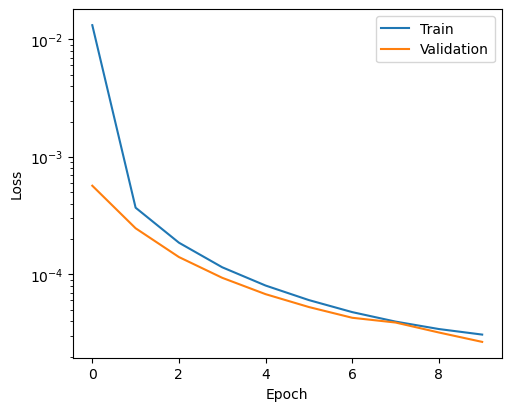

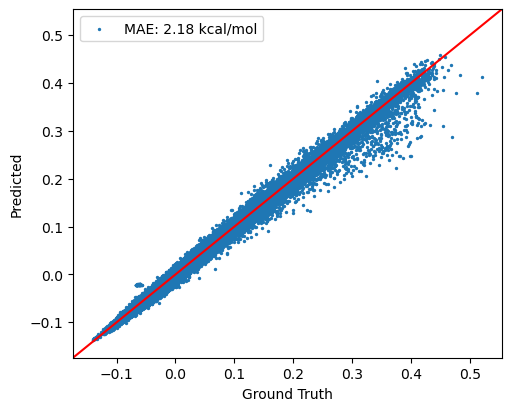

Experiment 1 - Validation Loss: 2.6663946453974443e-05

---- Experiment 2 ----
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 10/10 [06:59<00:00, 41.96s/it]


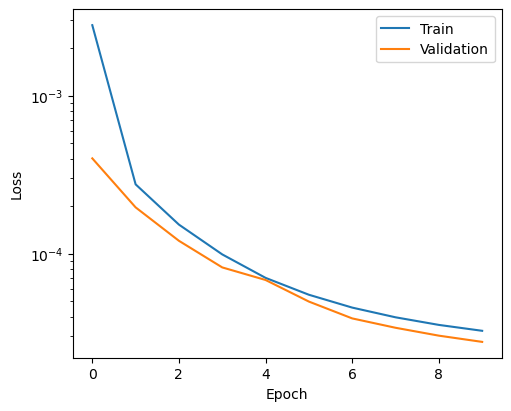

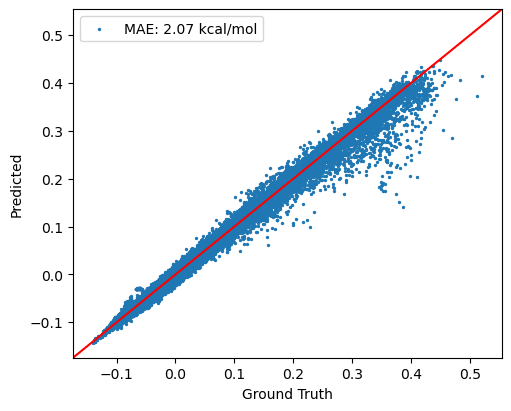

Experiment 2 - Validation Loss: 2.7722288024208172e-05

---- Experiment 3 ----
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 10/10 [08:00<00:00, 48.05s/it]


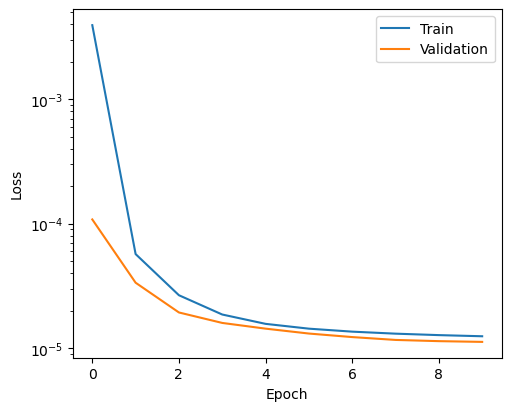

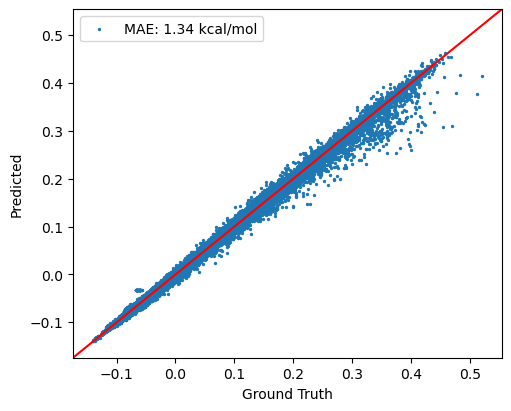

Experiment 3 - Validation Loss: 1.122158933060691e-05


In [14]:
# We will experiment various combination of hyperparameters
# Grid search enables finding optimal hyperparameter setting more efficiently than random search
# Define hyperparameter grids
hyperparams = [
    # (dropout_rate, learning_rate, batch_size, l2, l1, epoch)
    (0.4, 1e-4, 4096, 1e-5, 0.0, 10), # best setting in ckpt3
    (0.0, 1e-4, 4096, 1e-5, 0.0, 10),
    (0.4, 1e-4, 1024, 1e-5, 0.0, 10),
    
]

# Record each experiment's hyperparameters and validation loss
results = []

best_val_loss = np.inf
best_params = None
best_trainer = None

# Grid search loop
for idx, params in enumerate(hyperparams):
    print(f"\n---- Experiment {idx+1} ----")
    dropout_rate, learning_rate, batch_size, l2, l1, epoch = params
    
    # Create a new ANI model using the specified dropout rate
    model = create_ani_model(dropout_rate)
    
    # Initialize the trainer with current hyperparameter settings
    trainer = ANITrainer(model, batch_size, learning_rate, epoch, l2, l1)
    
    trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
    val_loss = trainer.evaluate(val_data, draw_plot=True)
    print(f"Experiment {idx+1} - Validation Loss:",val_loss)
    
    exp_result = {
        'experiment': idx+1,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'l2': l2,
        'l1': l1,
        'epoch': epoch,
        'val_loss': val_loss
    }
    results.append(exp_result)
    
    # Based on the current validation loss, update best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_trainer = trainer

Grid search results saved to grid_search_results.pkl

---- Best Hyperparameter Combination ----
Dropout Rate: 0.4, Learning Rate: 0.0001, Batch Size: 1024, L2: 1e-05, L1: 0.0, Epoch: 10
Best Validation Loss: 1.122158933060691e-05


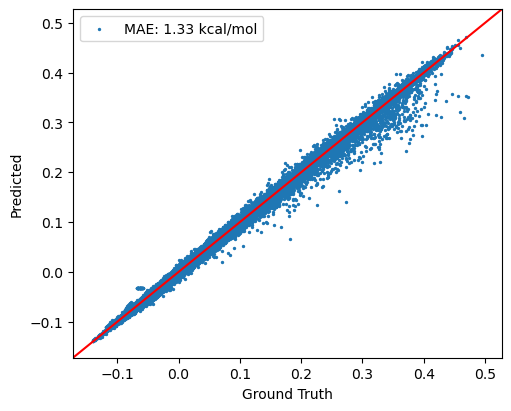

Test Loss: 1.126758717248159e-05


In [16]:
import pickle
with open("grid_search_results.pkl", "wb") as f:
    pickle.dump(results, f)
print("Grid search results saved to grid_search_results.pkl")

print("\n---- Best Hyperparameter Combination ----")
print(f"Dropout Rate: {best_params[0]}, Learning Rate: {best_params[1]}, Batch Size: {best_params[2]}, "
      f"L2: {best_params[3]}, L1: {best_params[4]}, Epoch: {best_params[5]}")
print(f"Best Validation Loss:", best_val_loss)

# Evaluate the best model on test_data
test_loss = best_trainer.evaluate(test_data, draw_plot=True)
print(f"Test Loss:", test_loss)


Grid Search Results:
   experiment  dropout_rate  learning_rate  batch_size       l2   l1  epoch  \
0           1           0.4         0.0001        4096  0.00001  0.0     10   
1           2           0.0         0.0001        4096  0.00001  0.0     10   
2           3           0.4         0.0001        1024  0.00001  0.0     10   

   val_loss  
0  0.000027  
1  0.000028  
2  0.000011  


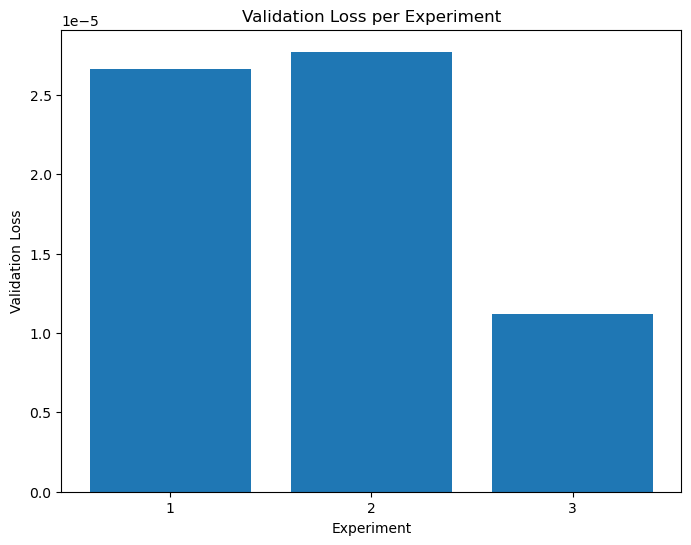

In [17]:
import pandas as pd
df_results = pd.DataFrame(results)
print("\nGrid Search Results:")
print(df_results)

# Visualization of validation loss for each experiment
plt.figure(figsize=(8, 6))
plt.bar(df_results['experiment'].astype(str), df_results['val_loss'])
plt.xlabel('Experiment')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Experiment')
plt.savefig("val_loss_bar.png")
plt.show()

## Interpretation of Results

In checkpoint 3, we used ANI-1 subset of s01 to s06, and we found out hyperparameters as dropout=0.4, batch_size=4096, learning_rate=1e-4, epoch=10, l2=1e-5 as the best model. In checkpoint 4, we checked on the effect of batch size and dropout rate before running k-fold cross validation. The best result was when dropout rate was applied as 0.4, and when batch size was shrinken to 1024. This made MAE 1.33kcal/mol and loss as 0.000011, which is more than two times smaller than the best model we got in checkpoint3.

## 4. K-fold cross validation and Final training

In [18]:
from sklearn.model_selection import KFold

In [22]:
class ANIIndexedSubset:
    def __init__(self, base_dataset, indices):
        self.base_dataset = base_dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.base_dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

    def collate(self, batch_size):
        subset = self.base_dataset.collate(batch_size=batch_size)
        return subset

    def cache(self):
        return self

def k_fold_cv_ani(dataset, k=5, runs=3,
                  dropout_rate=0.4, learning_rate=1e-4,
                  batch_size=1024, l2=1e-5, l1=0.0, epoch=10,
                  shuffle=True, base_seed=None):
    dataset_list   = list(dataset)           
    all_runs_losses, run_stats = [], []

    for run in range(1, runs + 1):
        seed = (base_seed + run) if base_seed is not None else np.random.randint(0, 1_000_000)
        kf   = KFold(n_splits=k, shuffle=shuffle, random_state=seed)

        print(f"\n===== Run {run}/{runs} | seed={seed} =====")
        fold_losses = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_list), 1):
            print(f"\n─── Fold {fold}/{k} ───")

            train_subset = ANIIndexedSubset(dataset, train_idx)
            val_subset   = ANIIndexedSubset(dataset, val_idx)

            model   = create_ani_model(dropout_rate)
            trainer = ANITrainer(model        = model,
                                 batch_size   = batch_size,
                                 learning_rate= learning_rate,
                                 epoch        = epoch,
                                 l2           = l2,
                                 l1           = l1)

            trainer.train(train_subset, val_subset,
                          early_stop=True, draw_curve=False)

            val_loss = trainer.evaluate(val_subset, draw_plot=True)
            print(f"Fold {fold} Validation Loss: {val_loss:.6f}")
            fold_losses.append(val_loss)

        run_mean, run_std = np.mean(fold_losses), np.std(fold_losses)
        print(f"Run {run} Summary → mean {run_mean:.6f}, std {run_std:.6f}")
        all_runs_losses.append(fold_losses)
        run_stats.append((run_mean, run_std))

    overall_mean = np.mean([m for m, _ in run_stats])
    overall_std  = np.std ([m for m, _ in run_stats])
    print("\n===== Overall Summary =====")
    print(f"Avg of run means : {overall_mean:.6f}")
    print(f"Std of run means : {overall_std:.6f}")

    return {
        "fold_losses_per_run": all_runs_losses,
        "run_stats"          : run_stats,   
        "overall_mean"       : overall_mean,
        "overall_std"        : overall_std
    }



===== Run 1/3 | seed=43 =====

─── Fold 1/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:28<00:00, 46.41s/it]


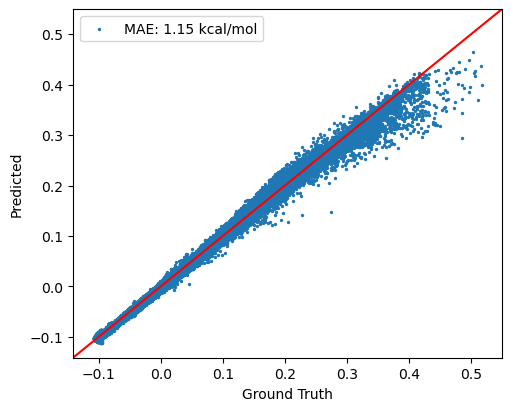

Fold 1 Validation Loss: 0.000009

─── Fold 2/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:28<00:00, 46.44s/it]


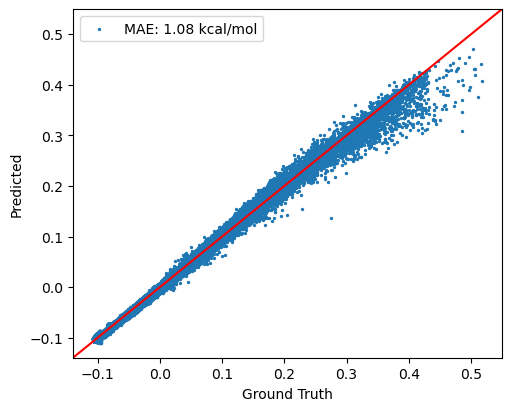

Fold 2 Validation Loss: 0.000008

─── Fold 3/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:27<00:00, 46.40s/it]


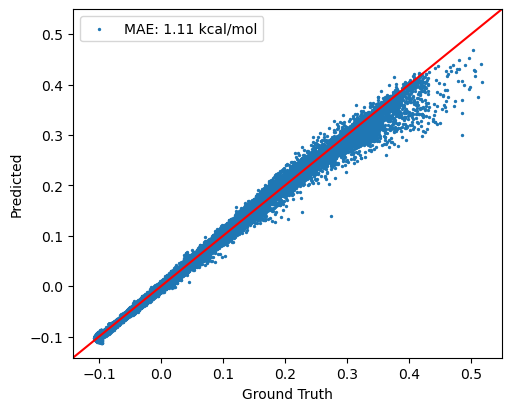

Fold 3 Validation Loss: 0.000009
Run 1 Summary → mean 0.000009, std 0.000000

===== Run 2/3 | seed=44 =====

─── Fold 1/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:44<00:00, 47.24s/it]


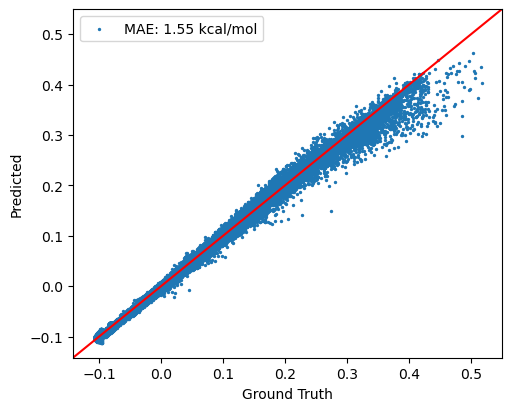

Fold 1 Validation Loss: 0.000013

─── Fold 2/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:31<00:00, 46.60s/it]


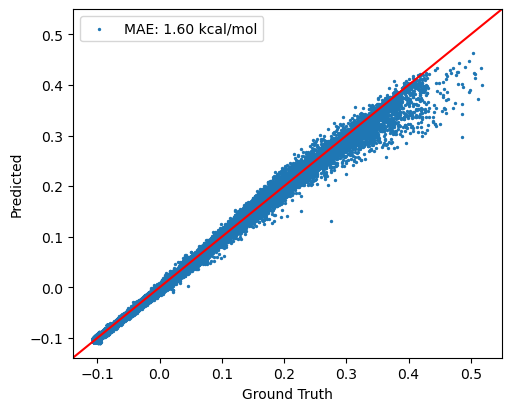

Fold 2 Validation Loss: 0.000013

─── Fold 3/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:30<00:00, 46.51s/it]


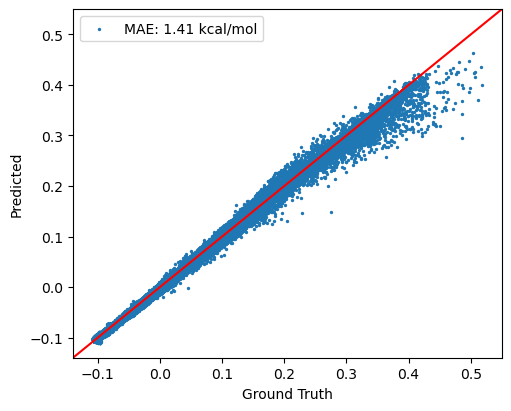

Fold 3 Validation Loss: 0.000012
Run 2 Summary → mean 0.000013, std 0.000001

===== Run 3/3 | seed=45 =====

─── Fold 1/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:30<00:00, 46.50s/it]


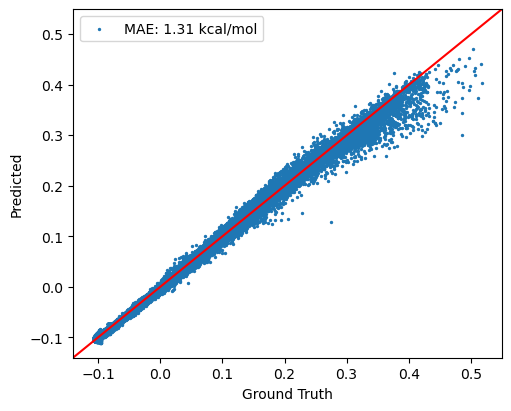

Fold 1 Validation Loss: 0.000011

─── Fold 2/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:44<00:00, 47.23s/it]


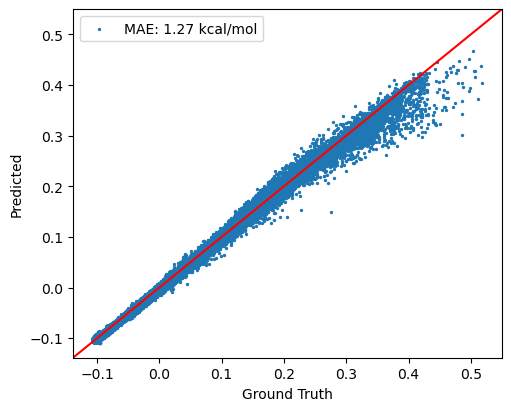

Fold 2 Validation Loss: 0.000010

─── Fold 3/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:35<00:00, 46.79s/it]


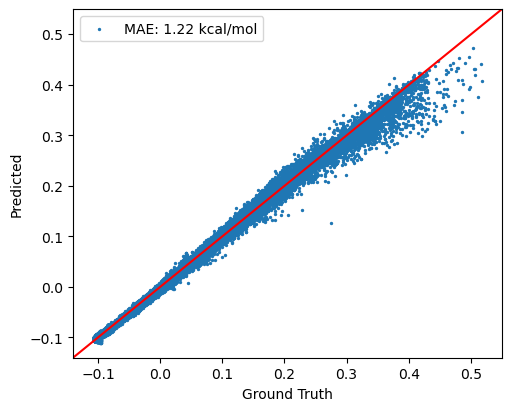

Fold 3 Validation Loss: 0.000010
Run 3 Summary → mean 0.000010, std 0.000000

===== Overall Summary =====
Avg of run means : 0.000011
Std of run means : 0.000002


In [23]:
results = k_fold_cv_ani(
    dataset       = dataset,
    k             = 3,
    runs          = 3,          # multiple runs
    dropout_rate  = 0.4,
    learning_rate = 1e-4,
    batch_size    = 1024,
    l2            = 1e-5,
    l1            = 0.0,
    epoch         = 20,
    base_seed     = 42        
)

Due to time conflict and processing power limit, we used s01-s04 dataset for this checkpoint.  For 3 run and 3-fold each, MAE varied from 1.08kcal/mol to 1.55kcal/mol, which is small enough.